# Introduction


In this project, I implement image-to-image translation from human selfies to anime faces using CycleGan.

In [25]:
# Imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
import random
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image as I



## Data Preparation / Loading

In this section I create the Faces dataset for the real and anime selfies. I also pre-process the data by resizing each image to be 128x128, normalizing the input, and transforming it into a tensor. Resizing the image to be 128x128 was done to reduce computation time, and normalizing the input is a standard procedure in computer vision that can speed up training.

In [7]:
class FacesDataset(Dataset):
    def __init__(self, realFacesRoot, animeFacesRoot):
        self.realRoot = realFacesRoot
        self.animeRoot = animeFacesRoot
        self.realFaces = os.listdir(realFacesRoot)
        self.animeFaces = os.listdir(animeFacesRoot)
        self.realFacesSize = len(self.realFaces)
        self.animeFacesSize = len(self.animeFaces)

        self.lengthDataset = max(self.realFacesSize,self.animeFacesSize)
        
        self.transformations = A.Compose(
            [A.Resize(width=128, height=128),
             A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
             ToTensorV2(),
            ],
            additional_targets={"image0": "image"})
        
    def __len__(self):
        return self.lengthDataset

    def __getitem__(self, index):
        realFace = self.realFaces[index % self.realFacesSize]
        animeFace = self.animeFaces[index % self.animeFacesSize]

        realFacePath = os.path.join(self.realRoot, realFace)
        animeFacePath = os.path.join(self.animeRoot, animeFace)

        realFace = np.array(I.open(realFacePath).convert("RGB"))
        animeFace = np.array(I.open(animeFacePath).convert("RGB"))
        transformedFaces= self.transformations(image=realFace, image0=animeFace)

        realFace = transformedFaces["image"]
        animeFace = transformedFaces["image0"]

        return realFace, animeFace

In [26]:
# Hyperparameters for the Loaders
BATCH_SIZE = 1
NUM_WORKERS = 2

facesDataset = FacesDataset("./data/trainA/realTrain", "./data/trainB/animeTrain")
facesTestDataset = FacesDataset("./data/testA/realTest", "./data/testB/animeTest")

facesLoader = torch.utils.data.DataLoader(facesDataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
facesTestLoader = torch.utils.data.DataLoader(facesTestDataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

# Visualization of Dataset

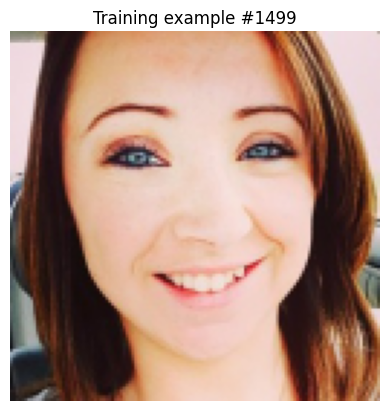

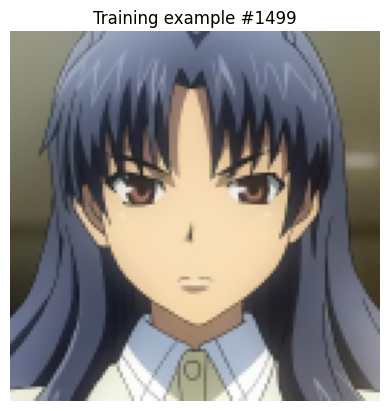

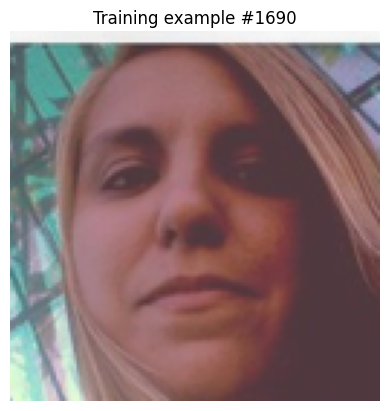

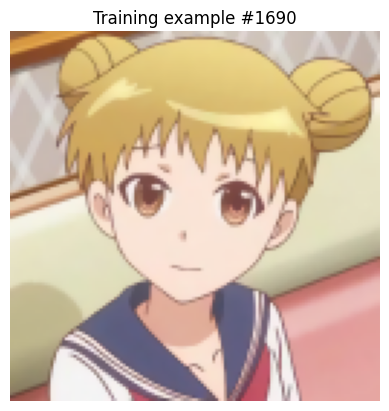

In [39]:
# Visualize a couple of images from the anime and face datasets
def visualize_samples(dataset, num_samples):
    for _ in range(num_samples):
        random_seg_img = random.randint(0, len(dataset) - 1)
        realFace, animeFace = dataset[random_seg_img]
        plt.imshow(realFace.permute(1, 2, 0)*.5 + .5)
        plt.title(f"Training example #{random_seg_img}")
        plt.axis('off')
        plt.show()
        plt.imshow(animeFace.permute(1, 2, 0)*.5+.5)
        plt.title(f"Training example #{random_seg_img}")
        plt.axis('off')
        plt.show()
visualize_samples(facesDataset, 2)


# Constructing the Generative Model

In [24]:
# A single Residual block, for use in the Generator Model
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.num_channels = num_channels
        self.single_residual_block = nn.Sequential(
            nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(self.num_channels),
            nn.ReLU(),
            nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(self.num_channels),
        )
    def forward(self, x):
        return x + self.single_residual_block(x)

# Generator Model
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        
        # Downsampling layers
        self.downSampleLayers = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels = 64, kernel_size = 7, stride = 1, padding = 3, padding_mode = "reflect"),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels = 128, kernel_size = 3, stride =2, padding=1, padding_mode = "reflect"),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels = 256, kernel_size = 3, stride =2, padding=1, padding_mode = "reflect"),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        )
        # At the end of downsampling, input is 32x32x256

        # 6 residual blocks, as recommended in the paper for 128 x 128 images
        self.residualLayers = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Upsampling layers
        self.upSampleLayers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        )
        # At the end of upsampling layers input is 128x128x64

        # Final layer, reverts back to 3 color channels. Output is 128x128x3
        self.out = nn.Conv2d(64, 3, 7, 1, 3, padding_mode= "reflect")

    def forward(self, x):
        x = self.downSampleLayers(x)
        x = self.residualLayers(x)
        x = self.upSampleLayers(x)
        x = torch.tanh(self.out(x))
        return x

# Constructing the Discriminator Model

In [14]:
# Discriminative Model

class DiscriminativeModel(nn.Module):
    def __init__(self):
        super(DiscriminativeModel, self).__init__()
        
        # Discriminator Layers
        self.discriminatorLayers = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            # No instance norm for the first layer, as the cycleGan paper suggests
            nn.LeakyReLU(0.2),
            # Output is 64x64x64

            nn.Conv2d(in_channels =64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            # Output is 32x32x128

            nn.Conv2d(in_channels =128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            # Output is 16x16x256

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 1, padding = 1, padding_mode = "reflect"),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            # Output is 8x8x512
        )

        self.out = nn.Sequential(
            nn.Conv2d(512, 1, 4,1,1, padding_mode="reflect",),
        )
        # Results in a binary label

    def forward(self, x):
        x = self.discriminatorLayers(x)
        x = torch.sigmoid(self.out(x))
        return x


In [15]:
# Save a model
def saveModel(model, optimizer, epochs, location):
    to_save = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "numEpochs": epochs
    }
    torch.save(to_save, location)

# Load a model
def loadModel(model, optimizer, lr, location):
    to_load = torch.load(location)
    model.load_state_dict(to_load["state_dict"])
    optimizer.load_state_dict(to_load["optimizer"])
    numEpochs = int(to_load["curEpochs"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    return numEpochs

# Training

In [10]:
# Training
def train(facesLoader, genRealModel, genAnimeModel, discRealModel, discAnimeModel, genOpt, discOpt, genScaler, discScaler, lambdaVal = 10, epochs=20,  startingEpochs = 0):
    mseLoss = nn.MSELoss()
    l1Loss = nn.L1Loss()
    
    genRealModel.train()
    genAnimeModel.train()
    discRealModel.train()
    discAnimeModel.train()
    
    for e in range(epochs):
        for idx, (realFace, animeFace) in enumerate(facesLoader):
            realFace = realFace.to(DEVICE)
            animeFace = animeFace.to(DEVICE)

            # Training discriminators
            with torch.cuda.amp.autocast():
                generatedAnimeFace = genAnimeModel(realFace)
                animeDiscOnGenerated = discAnimeModel(generatedAnimeFace.detach())
                animeDiscOnAnime = discAnimeModel(animeFace) 
                animeDiscOriginalLoss = mseLoss(animeDiscOnAnime, torch.ones_like(animeDiscOnAnime))
                animeDiscGeneratedLoss = mseLoss(animeDiscOnGenerated, torch.ones_like(animeDiscOnGenerated))
                animeDiscriminatorLoss = animeDiscOriginalLoss + animeDiscGeneratedLoss 

                generatedRealFace = genRealModel(animeFace)
                realDiscOnGenerated = discRealModel(generatedRealFace.detach()) 
                realDiscOnOriginal = discRealModel(realFace)
                realDiscOriginalLoss = mseLoss(realDiscOnOriginal, torch.ones_like(realDiscOnOriginal))
                realDiscGeneratedLoss = mseLoss(realDiscOnGenerated, torch.ones_like(realDiscOnGenerated))
                realDiscriminatorLoss = realDiscOriginalLoss + realDiscGeneratedLoss

                discriminatorLoss = (animeDiscriminatorLoss + realDiscriminatorLoss) / 2

            discOpt.zero_grad()
            discScaler.scale(discriminatorLoss).backward()
            discScaler.step(discOpt)
            discScaler.update()

            # Train generators
            with torch.cuda.amp.autocast():
                # Losses from discriminators
                discAnimeGenerated = discAnimeModel(generatedAnimeFace)
                discRealGenerated = discRealModel(generatedRealFace)
                lossGeneratedAnime = mseLoss(discAnimeGenerated, torch.ones_like(discAnimeGenerated))
                lossGeneratedReal = mseLoss(discRealGenerated, torch.ones_like(discRealGenerated))
                # Losses from cycling
                cycledAnimeFace = genAnimeModel(generatedRealFace)
                cycledRealFace = genRealModel(generatedAnimeFace)
                lossCycledAnimeFace = l1Loss(animeFace, cycledAnimeFace) * lambdaVal
                lossCycledRealFace = l1Loss(realFace, cycledRealFace) * lambdaVal

                generatorLoss = lossGeneratedAnime + lossGeneratedReal + lossCycledAnimeFace + lossCycledRealFace

            genOpt.zero_grad()
            genScaler.scale(generatorLoss).backward()
            genScaler.step(genOpt)
            genScaler.update()

            if idx % 250 == 0:
                print(f"Currently on epoch: {e + startingEpochs}, index: {idx}")

        # Saving models after each epoch
        saveModel(genRealModel, genOpt, e + startingEpochs, "savedModels/genRealModel")
        saveModel(genAnimeModel, genOpt, e + startingEpochs, "savedModels/genAnimeModel")
        saveModel(discRealModel, discOpt, e + startingEpochs, "savedModels/discRealModel")
        saveModel(discAnimeModel, discOpt, e + startingEpochs, "savedModels/discAnimeModel")
        print(f"SAVED EPOCH {e + startingEpochs} MODEL!")

In [12]:
SAVED_MODELS_EXIST = True
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

animeFaceGenerator = GeneratorModel().to(DEVICE)
realFaceGenerator = GeneratorModel().to(DEVICE)
animeFaceDiscriminator = DiscriminativeModel().to(DEVICE)
realFaceDiscriminator = DiscriminativeModel().to(DEVICE)

genOpt = optim.Adam(list(animeFaceGenerator.parameters()) + list(realFaceGenerator.parameters()), lr= 0.00001, betas = (0.9,0.999))
discOpt = optim.Adam(list(animeFaceDiscriminator.parameters()) + list(realFaceDiscriminator.parameters()), lr= 0.00001, betas = (0.9,0.999))

curNumEpochs = 0
if SAVED_MODELS_EXIST:
    curNumEpochs = loadModel(realFaceGenerator, genOpt, 0.0002, "savedModels/genRealModel")
    loadModel(animeFaceGenerator, genOpt, 0.0002, "savedModels/genAnimeModel")
    loadModel(realFaceDiscriminator, discOpt, 0.0002, "savedModels/discRealModel")
    loadModel(animeFaceDiscriminator, discOpt, 0.0002, "savedModels/discAnimeModel")
    print("LOADED SAVED MODELS")

genScaler = torch.cuda.amp.GradScaler()
discScaler = torch.cuda.amp.GradScaler()

train(facesLoader, realFaceGenerator, animeFaceGenerator, realFaceDiscriminator, animeFaceDiscriminator, genOpt, discOpt, genScaler, discScaler, epochs = 1, startingEpochs = curNumEpochs)

LOADED SAVED MODELS
cuda:0
Currently on epoch: 62, index: 0
Currently on epoch: 62, index: 250
Currently on epoch: 62, index: 500
Currently on epoch: 62, index: 750
Currently on epoch: 62, index: 1000
Currently on epoch: 62, index: 1250
Currently on epoch: 62, index: 1500
Currently on epoch: 62, index: 1750
Currently on epoch: 62, index: 2000
Currently on epoch: 62, index: 2250
Currently on epoch: 62, index: 2500
Currently on epoch: 62, index: 2750
Currently on epoch: 62, index: 3000
Currently on epoch: 62, index: 3250
SAVED EPOCH 62 MODEL!


# Visualizing Results

In [20]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 16))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

print(DEVICE)
animeFaceGenerator = GeneratorModel().to(DEVICE)
realFaceGenerator = GeneratorModel().to(DEVICE)
genOpt = optim.Adam(list(animeFaceGenerator.parameters()) + list(realFaceGenerator.parameters()), lr= 1e-5, betas = (0.9,0.999))

loadModel(animeFaceGenerator, genOpt, 1e-5, "savedModels/genAnimeModel")
loadModel(realFaceGenerator, genOpt, 1e-5, "savedModels/genRealModel")

animeFaceGenerator.eval()
facesList = []
for idx, (realFace, _) in enumerate(facesTestLoader):
    if idx % 2 == 0:
        realFace = realFace[0]
        realFace = realFace.to(DEVICE)
        generated_face = animeFaceGenerator(realFace)
        facesList.append(realFace.detach().cpu()*.5+.5)
        facesList.append(generated_face.detach().cpu()*.5 + .5)
        



cuda:0


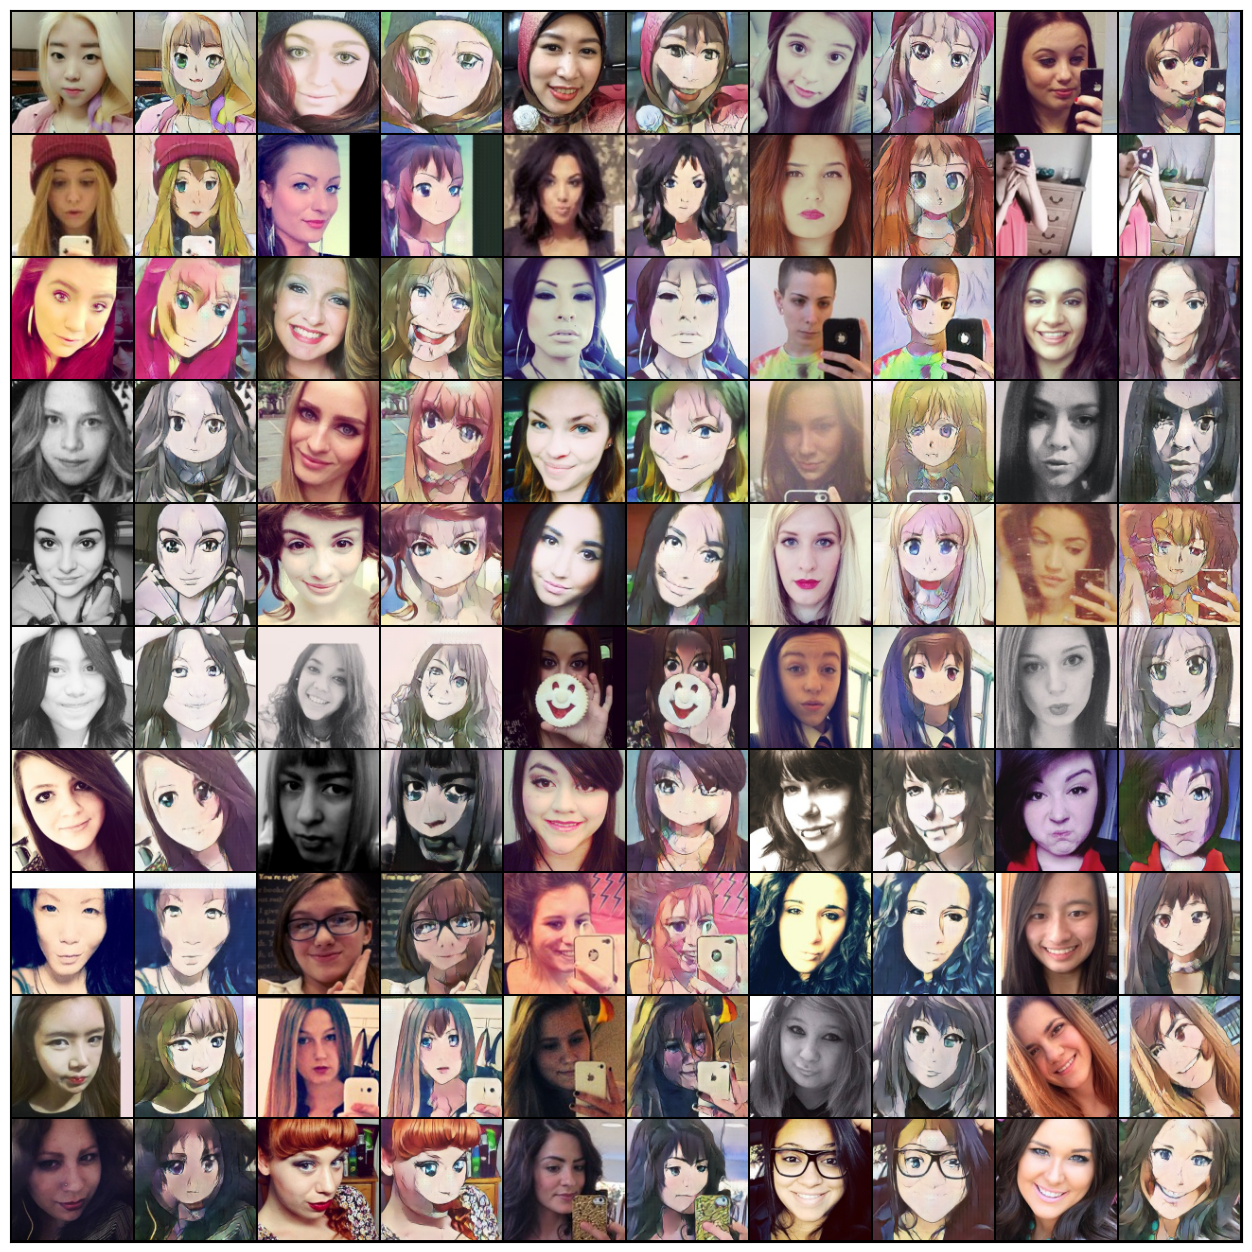

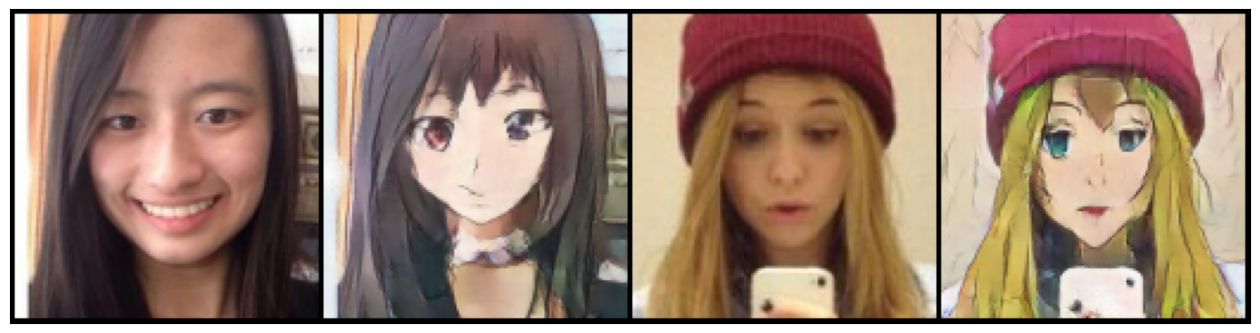

In [23]:
# Grid of 50 selfies followed by their corresponding generated anime face
faces_grid = torchvision.utils.make_grid(facesList, nrow=10)
show(faces_grid)

# 2 specific examples for closer evaluation 
faces_grid = torchvision.utils.make_grid(facesList[78:80]+ facesList[10:12], nrow=4)
show(faces_grid)


# Conclusions

As can be seen by the output above, my CycleGAN implementation is able to generate faces that exhibit some anime-like qualities while still retaining the look of the original face. The results are not fully convincing, but would continue to improve in quality with more training (i.e. 100 or 200 epochs instead of 62)